# Decide threshold

The goal of this notebook is to define a threshold to determine if a sample if PAO1 or not (likewise, if a sample is PA14 or not). We used known labels from SRA to do this. Specifically, we examined the distribution of PAO1 samples (grey) vs non-PAO1 samples (blue). We define the threshold to be one that separated between the two distributions. We use this threshold in [1_create_compendia.ipynb](1_create_compendia.ipynb) to partition gene expression data into PAO1 and PA14 compendia.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import pandas as pd
import seaborn as sns
from textwrap import fill
import matplotlib.pyplot as plt
from scripts import paths, utils

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Raw (TPM) expression data files
pao1_expression_filename = paths.PAO1_GE
pa14_expression_filename = paths.PA14_GE

# File containing table to map sample id to strain name
sample_to_strain_filename = paths.SAMPLE_TO_STRAIN

In [3]:
# Load expression data
# Matrices will be sample x gene after taking the transpose
pao1_expression = pd.read_csv(pao1_expression_filename, index_col=0, header=0).T
pa14_expression = pd.read_csv(pa14_expression_filename, index_col=0, header=0).T

In [4]:
# Load metadata
# Set index to experiment id, which is what we will use to map to expression data
sample_to_strain_table_full = pd.read_csv(sample_to_strain_filename, index_col=2)

## Format expression data

Format index to only include experiment id. This will be used to map to expression data and SRA labels later

In [5]:
# Format expression data indices so that values can be mapped to `sample_to_strain_table`
pao1_index_processed = pao1_expression.index.str.split(".").str[0]
pa14_index_processed = pa14_expression.index.str.split(".").str[0]

print(
    f"No. of samples processed using PAO1 reference after filtering: {pao1_expression.shape}"
)
print(
    f"No. of samples processed using PA14 reference after filtering: {pa14_expression.shape}"
)
pao1_expression.index = pao1_index_processed
pa14_expression.index = pa14_index_processed

No. of samples processed using PAO1 reference after filtering: (2767, 5563)
No. of samples processed using PA14 reference after filtering: (2767, 5891)


In [6]:
pao1_expression.head()

,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
ERX541572,5793.218939,766.512255,1608.330977,1663.466070,176.163343,384.600886,295.846835,453.183561,611.865046,43.032267,...,1.344758,75.306467,447.804528,10.758067,65.893159,44.377025,56.479850,2033.274614,184.231893,1.344758
ERX541573,4416.506898,797.782811,1770.117221,1562.763979,313.958581,324.501966,333.873864,415.877970,550.599003,38.659079,...,1.171487,103.090877,698.206395,18.743796,138.235494,39.830566,96.061954,1315.580171,91.376005,1.171487
ERX541574,3825.086116,644.433113,1852.251003,1589.338107,260.936107,270.820051,363.729119,363.729119,423.032780,67.210815,...,1.976789,128.491265,468.498920,19.767887,73.141182,33.605408,55.350083,1759.341934,67.210815,3.953577
ERX541575,3834.097653,789.216207,1926.825153,1610.427665,289.734779,261.294555,250.629471,520.811596,666.567742,53.325419,...,1.777514,124.425979,611.464809,15.997626,177.751398,21.330168,108.428353,1486.001686,56.880447,1.777514
ERX541576,3515.165133,853.775186,2185.277130,1683.341246,183.989360,245.319146,253.388855,380.890253,551.968079,66.171612,...,1.613942,90.380738,745.641089,11.297592,130.729282,50.032194,95.222563,1273.400041,72.627379,1.613942


In [7]:
pa14_expression.head()

,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_19205,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845
ERX541572,204.761199,49.806778,8.301130,16.602259,22.136346,11.068173,13.835216,74.710167,77.477210,5.534086,...,58.107908,166.022594,2692.333064,204.761199,27.670432,16.602259,1090.215033,520.204128,110.681729,2.767043
ERX541573,163.421371,44.569465,18.908258,24.310617,9.454129,18.908258,6.752949,63.477723,56.724773,9.454129,...,55.374184,202.588477,1755.766798,67.529492,5.402359,13.505898,1493.752368,598.311301,62.127133,1.350590
ERX541574,201.758337,14.497605,7.248803,15.705739,6.040669,18.122006,9.665070,48.325350,59.198554,8.456936,...,67.655490,224.712879,2213.301042,77.320560,7.248803,13.289471,1680.514056,885.562044,164.306191,1.208134
ERX541575,186.502345,46.124236,10.027008,30.081023,10.027008,14.037811,6.016205,44.118834,42.113433,8.021606,...,40.108031,240.648187,1500.040368,64.172850,6.016205,12.032409,1251.370574,677.825728,140.378109,2.005402
ERX541576,223.958038,23.864381,12.850051,31.207268,14.685773,11.014330,11.014330,40.385876,55.071649,9.178608,...,69.757422,212.943708,1672.342397,62.414535,1.835722,14.685773,1325.391010,627.816794,104.636132,1.835722


## Format SRA annotations

In [8]:
# Since experiments have multiple runs there are duplicated experiment ids in the index
# We will need to remove these so that the count calculations are accurate
sample_to_strain_table_full_processed = sample_to_strain_table_full[
    ~sample_to_strain_table_full.index.duplicated(keep="first")
]

assert (
    len(sample_to_strain_table_full.index.unique())
    == sample_to_strain_table_full_processed.shape[0]
)

In [9]:
# Aggregate boolean labels into a single strain label
aggregated_label = []
for exp_id in list(sample_to_strain_table_full_processed.index):
    if sample_to_strain_table_full_processed.loc[exp_id, "PAO1"].all() == True:
        aggregated_label.append("PAO1")
    elif sample_to_strain_table_full_processed.loc[exp_id, "PA14"].all() == True:
        aggregated_label.append("PA14")
    elif sample_to_strain_table_full_processed.loc[exp_id, "PAK"].all() == True:
        aggregated_label.append("PAK")
    elif (
        sample_to_strain_table_full_processed.loc[exp_id, "ClinicalIsolate"].all()
        == True
    ):
        aggregated_label.append("Clinical Isolate")
    else:
        aggregated_label.append("NA")

sample_to_strain_table_full_processed["Strain type"] = aggregated_label

sample_to_strain_table = sample_to_strain_table_full_processed["Strain type"].to_frame()

sample_to_strain_table.head()

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Strain type
Experiment,
SRX5057740,NA
SRX5057739,NA
SRX5057910,NA
SRX5057909,NA
SRX3573046,PAO1


## Label samples with SRA annotations

In [10]:
# Label samples with SRA annotations
# pao1_expression_label = pao1_expression_binned.join(
#    sample_to_strain_table, how='left')
pao1_expression_label = pao1_expression.merge(
    sample_to_strain_table, left_index=True, right_index=True
)
pa14_expression_label = pa14_expression.merge(
    sample_to_strain_table, left_index=True, right_index=True
)
print(pao1_expression_label.shape)
pao1_expression_label.head()

(2767, 5564)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1,Strain type
ERX541572,5793.218939,766.512255,1608.330977,1663.466070,176.163343,384.600886,295.846835,453.183561,611.865046,43.032267,...,75.306467,447.804528,10.758067,65.893159,44.377025,56.479850,2033.274614,184.231893,1.344758,NA
ERX541573,4416.506898,797.782811,1770.117221,1562.763979,313.958581,324.501966,333.873864,415.877970,550.599003,38.659079,...,103.090877,698.206395,18.743796,138.235494,39.830566,96.061954,1315.580171,91.376005,1.171487,NA
ERX541574,3825.086116,644.433113,1852.251003,1589.338107,260.936107,270.820051,363.729119,363.729119,423.032780,67.210815,...,128.491265,468.498920,19.767887,73.141182,33.605408,55.350083,1759.341934,67.210815,3.953577,NA
ERX541575,3834.097653,789.216207,1926.825153,1610.427665,289.734779,261.294555,250.629471,520.811596,666.567742,53.325419,...,124.425979,611.464809,15.997626,177.751398,21.330168,108.428353,1486.001686,56.880447,1.777514,NA
ERX541576,3515.165133,853.775186,2185.277130,1683.341246,183.989360,245.319146,253.388855,380.890253,551.968079,66.171612,...,90.380738,745.641089,11.297592,130.729282,50.032194,95.222563,1273.400041,72.627379,1.613942,NA


In [11]:
print(pa14_expression_label.shape)
pa14_expression_label.head()

(2767, 5892)


,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845,Strain type
ERX541572,204.761199,49.806778,8.301130,16.602259,22.136346,11.068173,13.835216,74.710167,77.477210,5.534086,...,166.022594,2692.333064,204.761199,27.670432,16.602259,1090.215033,520.204128,110.681729,2.767043,NA
ERX541573,163.421371,44.569465,18.908258,24.310617,9.454129,18.908258,6.752949,63.477723,56.724773,9.454129,...,202.588477,1755.766798,67.529492,5.402359,13.505898,1493.752368,598.311301,62.127133,1.350590,NA
ERX541574,201.758337,14.497605,7.248803,15.705739,6.040669,18.122006,9.665070,48.325350,59.198554,8.456936,...,224.712879,2213.301042,77.320560,7.248803,13.289471,1680.514056,885.562044,164.306191,1.208134,NA
ERX541575,186.502345,46.124236,10.027008,30.081023,10.027008,14.037811,6.016205,44.118834,42.113433,8.021606,...,240.648187,1500.040368,64.172850,6.016205,12.032409,1251.370574,677.825728,140.378109,2.005402,NA
ERX541576,223.958038,23.864381,12.850051,31.207268,14.685773,11.014330,11.014330,40.385876,55.071649,9.178608,...,212.943708,1672.342397,62.414535,1.835722,14.685773,1325.391010,627.816794,104.636132,1.835722,NA


## Get accessory gene expression

In [12]:
pao1_annot_filename = paths.GENE_PAO1_ANNOT
pa14_annot_filename = paths.GENE_PA14_ANNOT

core_acc_dict = utils.get_my_core_acc_genes(
    pao1_annot_filename, pa14_annot_filename, pao1_expression, pa14_expression
)

Number of PAO1 core genes: 5366
Number of PA14 core genes: 5363
Number of PAO1 core genes in my dataset: 5361
Number of PA14 core genes in my dataset: 5357
Number of PAO1-specific genes: 202
Number of PA14-specific genes: 534


In [13]:
pao1_acc = core_acc_dict["acc_pao1"]
pa14_acc = core_acc_dict["acc_pa14"]

In [14]:
# Create accessory df
# accessory gene ids | median accessory expression | strain label

# PAO1
pao1_acc_expression = pao1_expression_label[pao1_acc]
pao1_acc_expression["median_acc_expression"] = pao1_acc_expression.median(axis=1)

# PA14
pa14_acc_expression = pa14_expression_label[pa14_acc]
pa14_acc_expression["median_acc_expression"] = pa14_acc_expression.median(axis=1)

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [15]:
# Add back labels
pao1_acc_expression["Strain type"] = pao1_expression_label["Strain type"]
pa14_acc_expression["Strain type"] = pa14_expression_label["Strain type"]

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
pao1_acc_expression.head()

,PA0819,PA2190,PA2192,PA1384,PA0643,PA0497,PA1372,PA2186,PA2234,PA2185,...,PA1555.1,PA0203,PA1834,PA3510,PA2734,PA2101,PA0716,PA3067,median_acc_expression,Strain type
ERX541572,10.758067,76.651226,5.379033,174.818585,209.782301,130.441559,2776.925977,2.689517,106.235909,14.792342,...,56.479850,13.447583,51.100817,1.344758,1048.911507,36.308475,2029.240339,51.100817,82.030259,NA
ERX541573,5.857436,12.886360,2.342974,101.919390,228.440012,60.917337,2351.174892,1.171487,36.316104,17.572309,...,96.061954,16.400821,51.545439,5.857436,633.774597,29.287181,2231.683194,36.316104,82.589850,NA
ERX541574,9.883943,7.907155,7.907155,209.539601,247.098586,41.512562,1757.365146,1.976789,55.350083,29.651830,...,55.350083,13.837521,69.187604,5.930366,533.732946,86.978702,2202.142601,21.744676,87.967097,NA
ERX541575,21.330168,8.887570,3.555028,62.212989,195.526538,248.851957,2595.170409,5.332542,39.105308,15.997626,...,108.428353,26.662710,44.437849,1.777514,595.467183,65.768017,2796.029489,23.107682,76.433101,NA
ERX541576,19.367301,20.981243,6.455767,87.152855,203.356661,187.217243,2876.044199,1.613942,64.557670,12.911534,...,95.222563,14.525476,66.171612,6.455767,661.716118,46.804311,3229.497443,25.823068,79.083146,NA


In [17]:
pa14_acc_expression.head()

,PA14_03370,PA14_59120,PA14_58720,PA14_31000,PA14_63420,PA14_28870,PA14_33300,PA14_22530,PA14_40740,PA14_33360,...,PA14_48460,PA14_22100,PA14_59370,PA14_53610,PA14_30990,PA14_23410,PA14_71830,PA14_13970,median_acc_expression,Strain type
ERX541572,13.835216,2.767043,2.767043,2.767043,2.767043,8.301130,2.767043,2.767043,35.971562,5.534086,...,8.301130,2.767043,2.767043,2.767043,2.767043,2.767043,279.471366,24.903389,5.534086,NA
ERX541573,1.350590,1.350590,1.350590,1.350590,4.051770,8.103539,1.350590,6.752949,47.270645,1.350590,...,1.350590,1.350590,1.350590,1.350590,2.701180,1.350590,495.666473,67.529492,2.701180,NA
ERX541574,2.416268,1.208134,1.208134,1.208134,10.873204,13.289471,1.208134,1.208134,54.366019,2.416268,...,1.208134,1.208134,1.208134,1.208134,2.416268,1.208134,366.064528,85.777497,2.416268,NA
ERX541575,2.005402,2.005402,2.005402,2.005402,12.032409,10.027008,2.005402,2.005402,44.118834,2.005402,...,6.016205,2.005402,2.005402,2.005402,2.005402,2.005402,334.902061,54.145842,4.010803,NA
ERX541576,3.671443,1.835722,1.835722,1.835722,7.342886,11.014330,1.835722,1.835722,34.878711,1.835722,...,1.835722,1.835722,1.835722,1.835722,1.835722,1.835722,488.301951,58.743092,3.671443,NA


In [18]:
# Merge PAO1 and PA14 accessory dataframes
pao1_pa14_acc_expression = pao1_acc_expression.merge(
    pa14_acc_expression,
    left_index=True,
    right_index=True,
    suffixes=["_pao1", "_pa14"],
)

pao1_pa14_acc_expression.head()

,PA0819,PA2190,PA2192,PA1384,PA0643,PA0497,PA1372,PA2186,PA2234,PA2185,...,PA14_48460,PA14_22100,PA14_59370,PA14_53610,PA14_30990,PA14_23410,PA14_71830,PA14_13970,median_acc_expression_pa14,Strain type_pa14
ERX541572,10.758067,76.651226,5.379033,174.818585,209.782301,130.441559,2776.925977,2.689517,106.235909,14.792342,...,8.301130,2.767043,2.767043,2.767043,2.767043,2.767043,279.471366,24.903389,5.534086,NA
ERX541573,5.857436,12.886360,2.342974,101.919390,228.440012,60.917337,2351.174892,1.171487,36.316104,17.572309,...,1.350590,1.350590,1.350590,1.350590,2.701180,1.350590,495.666473,67.529492,2.701180,NA
ERX541574,9.883943,7.907155,7.907155,209.539601,247.098586,41.512562,1757.365146,1.976789,55.350083,29.651830,...,1.208134,1.208134,1.208134,1.208134,2.416268,1.208134,366.064528,85.777497,2.416268,NA
ERX541575,21.330168,8.887570,3.555028,62.212989,195.526538,248.851957,2595.170409,5.332542,39.105308,15.997626,...,6.016205,2.005402,2.005402,2.005402,2.005402,2.005402,334.902061,54.145842,4.010803,NA
ERX541576,19.367301,20.981243,6.455767,87.152855,203.356661,187.217243,2876.044199,1.613942,64.557670,12.911534,...,1.835722,1.835722,1.835722,1.835722,1.835722,1.835722,488.301951,58.743092,3.671443,NA


## Plot distribution

In [19]:
# Get PAO1 samples that are labeled PAO1 and non-PAO1
pao1_sra = pao1_pa14_acc_expression.loc[
    pao1_pa14_acc_expression["Strain type_pao1"] == "PAO1",
    "median_acc_expression_pao1",
]

non_pao1_sra = pao1_pa14_acc_expression.loc[
    pao1_pa14_acc_expression["Strain type_pao1"] != "PAO1",
    "median_acc_expression_pao1",
]

In [20]:
pao1_threshold = 25

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


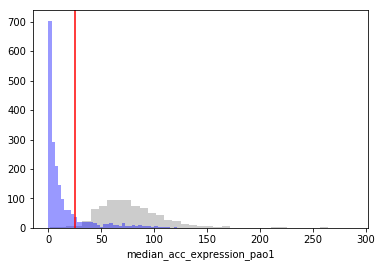

In [21]:
f = sns.distplot(pao1_sra, color="grey", kde=False)
f = sns.distplot(non_pao1_sra, color="blue", kde=False)
plt.axvline(pao1_threshold, 0, 100, color="red")

In [22]:
# Get PA14 samples that are labeled PA14 and non-PA14
pa14_sra = pao1_pa14_acc_expression.loc[
    pao1_pa14_acc_expression["Strain type_pa14"] == "PA14",
    "median_acc_expression_pa14",
]

non_pa14_sra = pao1_pa14_acc_expression.loc[
    pao1_pa14_acc_expression["Strain type_pa14"] != "PA14",
    "median_acc_expression_pa14",
]

In [23]:
pa14_threshold = 25

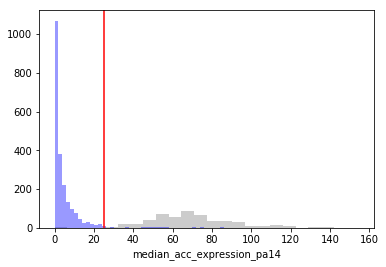

In [24]:
g = sns.distplot(pa14_sra, color="grey", kde=False)
g = sns.distplot(non_pa14_sra, color="blue", kde=False)
plt.axvline(pa14_threshold, 0, 100, color="red")

**Takeaway:**
Looks like using a threshold of 25 TPM separates between SRA-annotated PAO1 samples vs non-PAO1 samples. Similarly for PA14. This is the threshold we'll use to bin samples into PAO1 vs PA14 compendia.